In [2]:
!pip install tf-keras-vis lime mtcnn transformers

In [30]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, ConvLSTM2D, Attention, TimeDistributed, Concatenate, LSTM
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.feature import hog
from skimage import exposure
import kagglehub
import gc
from mtcnn import MTCNN
#from feat.detector import Detector
#from gaze_tracking import GazeTracking
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torch
from tf_keras_vis.utils.scores import BinaryScore
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Multiply, GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import backend as K
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
import shap
from skimage.segmentation import mark_boundaries

In [23]:
def Map_To_Threat_Level(Emotion):
  High_Threat_Emotions = ['angry' , 'disgust' , 'fear']
  Low_Threat_Emotions = ['happy' , 'neutral' , 'sad' , 'surprise']
  if Emotion in High_Threat_Emotions:
    return 'High Threat'
  else:
    return 'Low Threat'

In [24]:
def Preprocess_Face_Expression_Dataset(Imgs_Path , Img_Size=(128,128) , Sample_frac = 0.05):

  Emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  Data = {
      'Image_Paths': [],
      'Emotions': [],
      'Split': [],
      'Is_Augmented': [],
      'Threat_Level': [],
      'Image_Name': []
  }

  Data_Agm = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  All_Images = []

  Output_Dir = "Processed_Images"
  os.makedirs(Output_Dir, exist_ok=True)

  for Split in ['train', 'validation']:
      Split_Path = os.path.join(Imgs_Path, 'images', Split)
      if not os.path.exists(Split_Path):
          print(f"Directory '{Split_Path}' does not exist.")
          continue
      for Emotion in Emotions:
          Emotion_Path = os.path.join(Split_Path, Emotion)
          if not os.path.exists(Emotion_Path):
              print(f"Directory '{Emotion_Path}' does not exist.")
              continue
          for Image_Name in os.listdir(Emotion_Path):
              if not Image_Name.endswith(('.jpg', '.jpeg', '.png')):
                  continue
              Image_Path = os.path.join(Emotion_Path, Image_Name)
              All_Images.append({
                  'Image_Path': Image_Path,
                  'Emotion': Emotion,
                  'Split': Split,
                  'Image_Name': Image_Name
              })

  df_All = pd.DataFrame(All_Images)
  df_Sample = df_All.groupby(['Emotion', 'Split'], group_keys=False).apply(
      lambda x: x.sample(frac=Sample_frac, random_state=42)
  ).reset_index(drop=True)

  print(f"Sampled {len(df_Sample)} Images from {len(df_All)} Total Images.")

  df_Sample['Threat_Level'] = df_Sample['Emotion'].apply(Map_To_Threat_Level)

  for _, Row in df_Sample.iterrows():
      Image_Path = Row['Image_Path']
      Emotion = Row['Emotion']
      Split = Row['Split']
      Image_Name = Row['Image_Name']
      Threat_Level = Row['Threat_Level']

      Image = cv2.imread(Image_Path, cv2.IMREAD_GRAYSCALE)
      if Image is None:
          continue

      Image_Resized = cv2.resize(Image, Img_Size)

      output_path = os.path.join(Output_Dir, f"{Split}_{Emotion}_{Image_Name}")
      cv2.imwrite(output_path, Image_Resized)
      Data['Image_Paths'].append(output_path)
      Data['Emotions'].append(Emotion)
      Data['Split'].append(Split)
      Data['Is_Augmented'].append(False)
      Data['Threat_Level'].append(Threat_Level)
      Data['Image_Name'].append(Image_Name)

      Image_Reshaped = Image_Resized.reshape(1, Img_Size[0], Img_Size[1], 1)

      Augmented_Images = Data_Agm.flow(Image_Reshaped, batch_size=1)

      for i in range(3):

          Augmented_Image = next(Augmented_Images)[0].astype('uint8')
          Aug_Path = os.path.join(Output_Dir, f"{Split}_{Emotion}_Aug{i}_{Image_Name}")
          cv2.imwrite(Aug_Path , Augmented_Image)
          Data['Image_Paths'].append(Aug_Path)
          Data['Emotions'].append(Emotion)
          Data['Split'].append(Split)
          Data['Is_Augmented'].append(True)
          Data['Threat_Level'].append(Threat_Level)
          Data['Image_Name'].append(Image_Name)

  df = pd.DataFrame(Data)
  return df

In [28]:
def Face_Expression_EDA(Dataset_Name):

    df = pd.read_csv(Dataset_Name)
    print(f"Total Images in {Dataset_Name} : {len(df)}")
    print(f"Total Images in Train : {len(df[df['Split'] == 'train'])}")
    print(f"Total Images in Validation : {len(df[df['Split'] == 'validation'])}")
    print()

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Emotions', hue='Split')
    plt.title('Distribution of Emotions Across Splits')
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    print()

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='Threat_Level', hue='Split')
    plt.title('Distribution of Threat Levels Across Splits')
    plt.xlabel('Threat Level')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    print()

    Emotions = df['Emotions'].unique()
    print(f"Emotions in Dataset : {Emotions}")
    print()


    Num_Emotions = len(Emotions)
    Num_Cols = 4
    Num_Rows = (Num_Emotions + Num_Cols - 1) // Num_Cols


    for Idx, Emotion in enumerate(Emotions):

        Emotion_Images = df[df['Emotions'] == Emotion]['Image_Paths'].unique()

        if len(Emotion_Images) > 0:
            Img_Path = Emotion_Images[0]
            plt.figure()
            Img = cv2.imread(Img_Path, cv2.IMREAD_GRAYSCALE)
            plt.imshow(Img, cmap=plt.cm.gray)
            plt.title(Emotion)
            plt.axis('off')
            plt.show()

In [26]:
def Hog_Features(Dataset , Num_Samples = 100 , Num_Visualize = 10):

  df = pd.read_csv(Dataset)

  Emotions = df['Emotions'].unique()
  print(f"Emotions in Dataset : {Emotions}")
  print()

  Sample_per_Emotion = max(1 , Num_Samples // len(Emotions))
  print(f"Sample per Emotion : {Sample_per_Emotion}")

  df_Sample = df.groupby('Emotions' , group_keys=False).apply(
      lambda x: x.sample(n=min(Sample_per_Emotion , len(x))
      , random_state=42)).reset_index(drop=True)

  print(f"Total Samples in Dataset : {len(df_Sample)}")
  print()

  if len(df_Sample) < Num_Samples:
    Remaining = Num_Samples - len(df_Sample)
    Additional = df.drop(df_Sample.index).sample(n=Remaining , random_state=42)
    df_Sample = pd.concat([df_Sample , Additional] , ignore_index=True)


  df_Sample = df_Sample.sample(frac=1 , random_state=42).reset_index(drop=True)
  print(f"Total Samples in Sampled Dataset : {len(df_Sample)}")
  print()

  Hog_Features_Data = []
  Hog_Images = []

  for Img_Path in df_Sample['Image_Paths']:
    Img = cv2.imread(Img_Path, cv2.IMREAD_GRAYSCALE)
    Hog_Features, Hog_Img = hog(
        Img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        block_norm='L2-Hys'
    )

    Hog_Features_Data.append(Hog_Features)
    Hog_Images.append(Hog_Img)


  Visualize_Indices = df_Sample.sample(n=Num_Visualize , random_state=42).index
  print(f"Visualize Indices : {Visualize_Indices}")
  print()

  fig , axes = plt.subplots(nrows= 5 , ncols= 4 , figsize=(15 , 20) ,
                           sharex=False , sharey=False)
  axes = axes.flatten()


  for Idx , Sample_Idx in enumerate(Visualize_Indices):
    Img_Path = df_Sample.loc[Sample_Idx , 'Image_Paths']
    Emotion = df_Sample.loc[Sample_Idx , 'Emotions']
    Img = cv2.imread(Img_Path , cv2.IMREAD_GRAYSCALE)

    ax1 = axes[Idx * 2]
    ax1.axis('off')
    ax1.imshow(Img , cmap=plt.cm.gray)
    ax1.set_title(f'Original Image : {Emotion}')

    ax2 = axes[Idx * 2 + 1]
    Hog_Image_Rescaled = exposure.rescale_intensity(Hog_Images[Sample_Idx] , in_range=(0 , 10))
    ax2.axis('off')
    ax2.imshow(Hog_Image_Rescaled , cmap=plt.cm.gray)
    ax2.set_title('Hog Visualization')


  plt.show()

  df_Sample['Hog_Features'] = Hog_Features_Data
  df_Sample.to_csv('Images_Dataset_Hog.csv' , index=False)

  return df_Sample

In [5]:
Imgs_Path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
print("Path to dataset files:", Imgs_Path)

print(f"Directory Contents : {os.listdir(Imgs_Path)}")

print(f"Subdirectories in Images Contents : {os.listdir(os.path.join(Imgs_Path, 'images'))}")

Path to dataset files: /kaggle/input/face-expression-recognition-dataset
Directory Contents : ['images']
Subdirectories in Images Contents : ['validation', 'images', 'train']


In [6]:
Images_Dataset = Preprocess_Face_Expression_Dataset(Imgs_Path)
Images_Dataset.to_csv('Images_Dataset.csv' , index=False)

<ipython-input-4-aaf7ad2a34fd>:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_Sample = df_All.groupby(['Emotion', 'Split'], group_keys=False).apply(


Sampled 1795 Images from 35887 Total Images.


Total Images in Images_Dataset.csv : 7180
Total Images in Train : 5764
Total Images in Validation : 1416



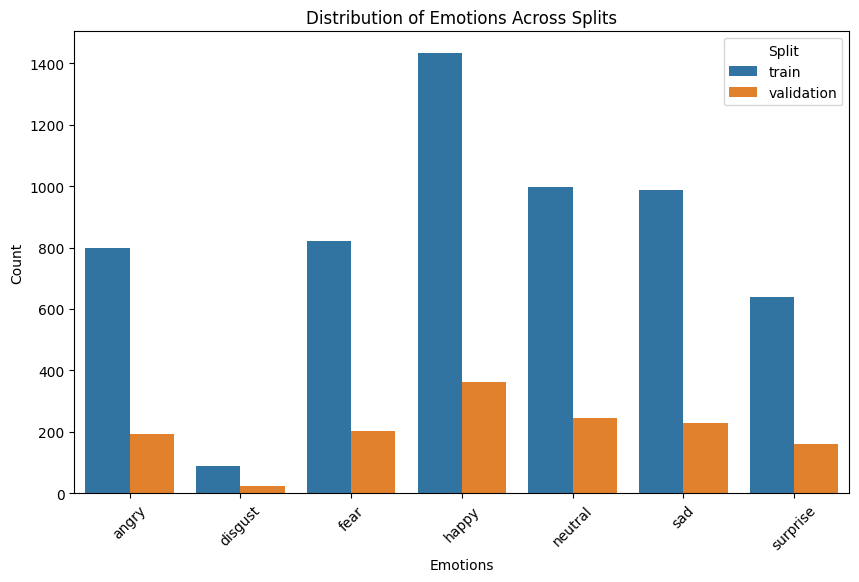

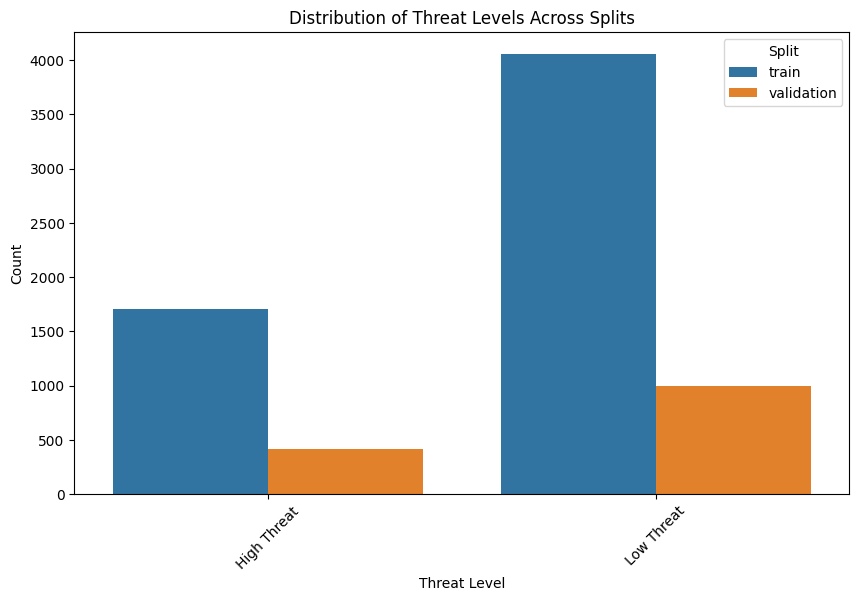


Emotions in Dataset : ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']



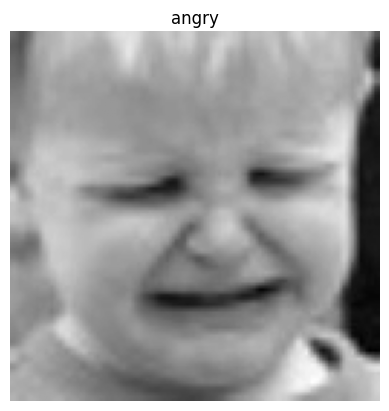

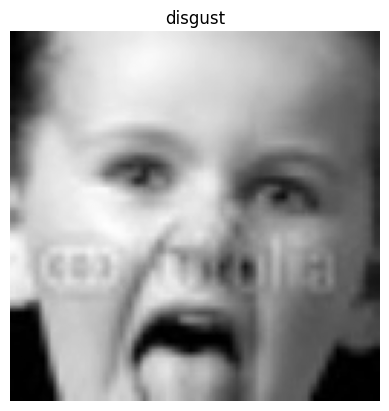

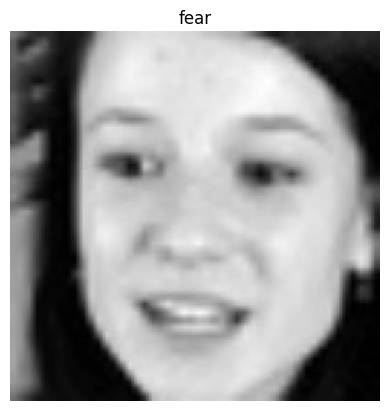

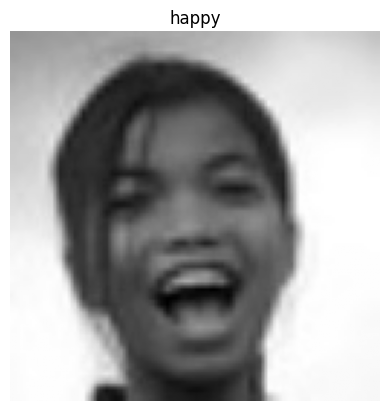

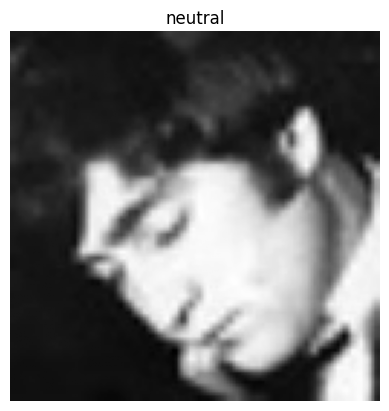

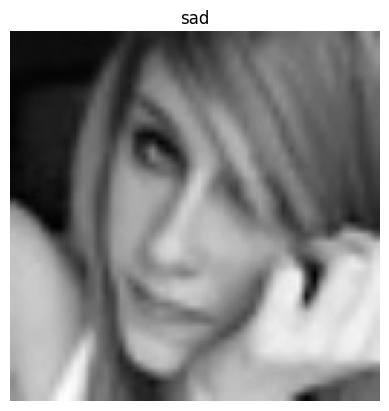

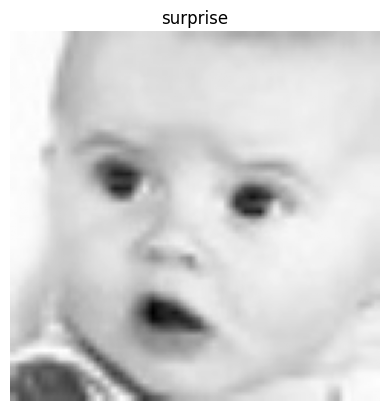

In [29]:
Dataset_Name = 'Images_Dataset.csv'
Face_Expression_EDA(Dataset_Name)

Emotions in Dataset : ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']

Sample per Emotion : 14
Total Samples in Dataset : 98

Total Samples in Sampled Dataset : 100



<ipython-input-4-aaf7ad2a34fd>:173: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_Sample = df.groupby('Emotions' , group_keys=False).apply(


Visualize Indices : Index([83, 53, 70, 45, 44, 39, 22, 80, 10, 0], dtype='int64')



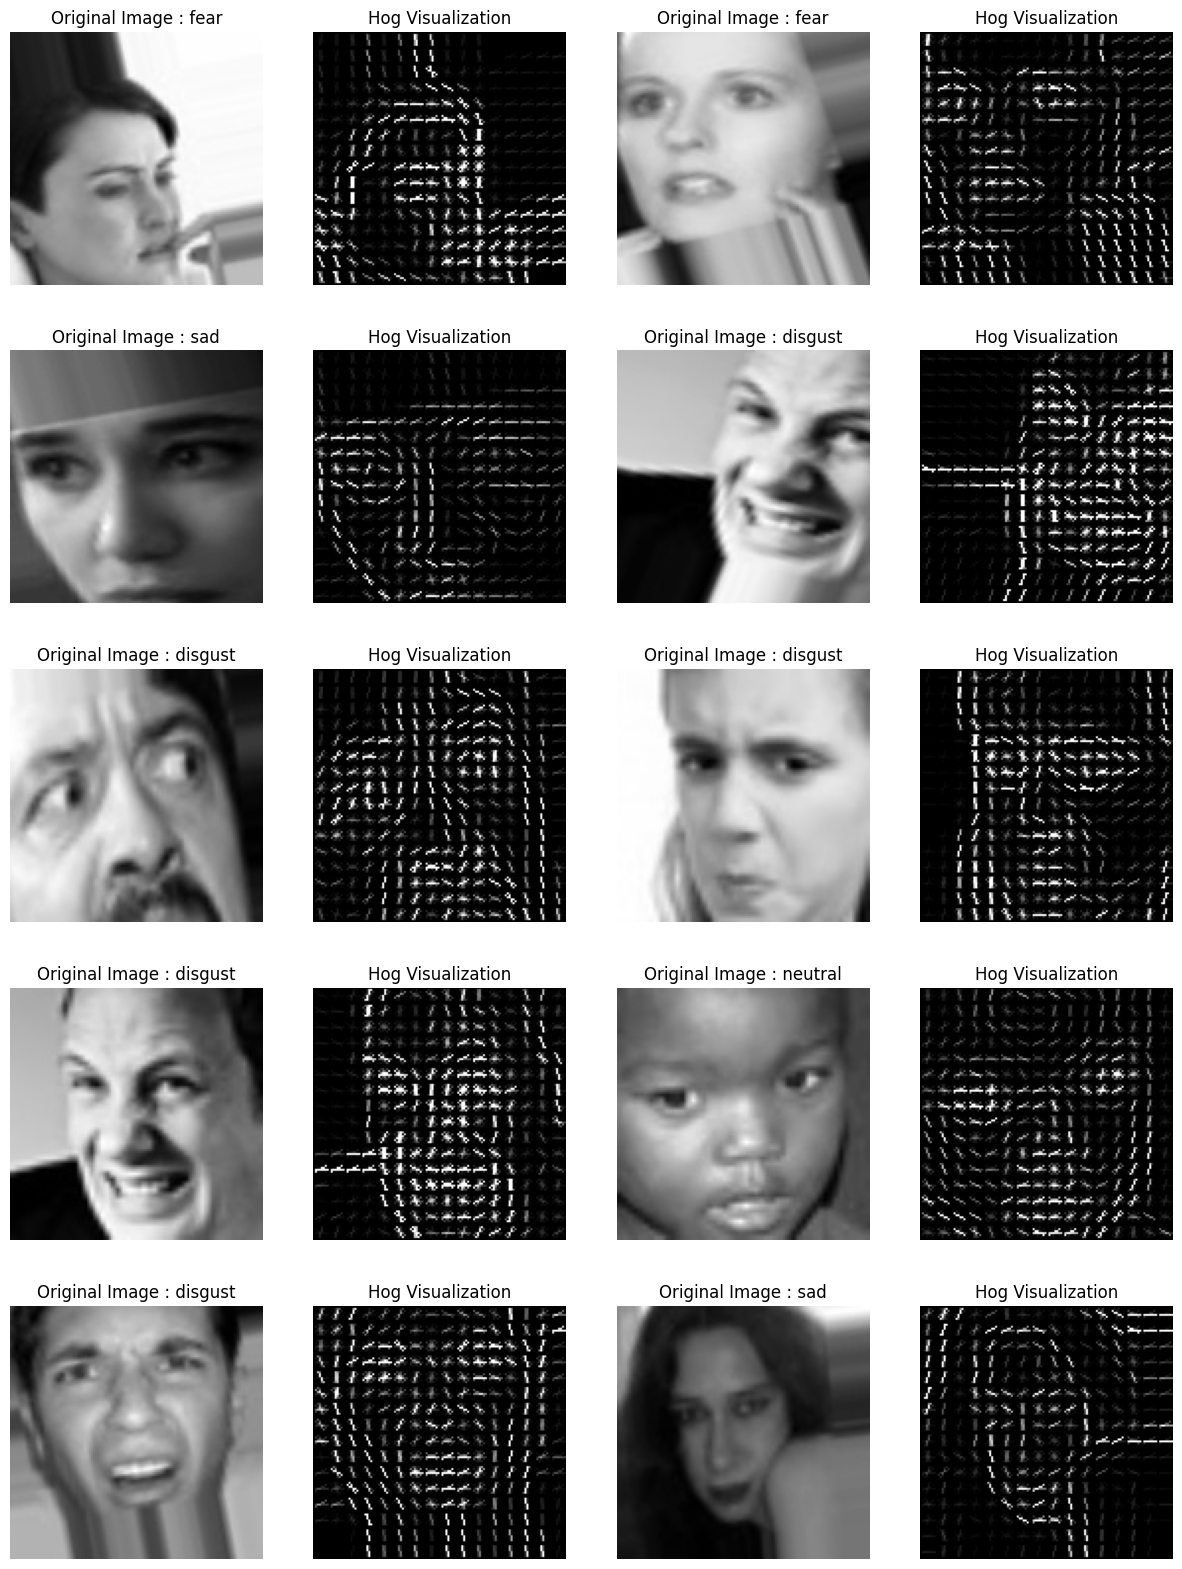

In [8]:
Hog_df = Hog_Features('Images_Dataset.csv')

In [31]:
def load_data(dataset_path, img_size=(128, 128)):

    df = pd.read_csv(dataset_path)
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = row['Image_Paths']
        label = 1 if row['Threat_Level'] == 'High Threat' else 0
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, img_size) / 255.0
        images.append(img)
        labels.append(label)

    images = np.array(images)[..., np.newaxis]
    labels = np.array(labels)
    return images, labels, df

In [32]:
def spatial_attention(input_feature):

    kernel_size = 7
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(input_feature)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool], axis=3)
    conv = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid')(concat)
    output = tf.keras.layers.multiply([input_feature, conv])
    return output

In [33]:
def build_facial_cue_net(input_shape=(128, 128, 1)):

    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = spatial_attention(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [34]:
def grad_cam(model, img, layer_name):

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)
    return heatmap

In [35]:
def lime_explanation(model, img, num_samples=1000):

    explainer = lime_image.LimeImageExplainer()
    Img_rgb = np.repeat(img[..., 0][..., np.newaxis], 3, axis=2)

    def model_predict(images):
        images = np.mean(images, axis=3, keepdims=True)
        return model.predict(images, verbose=0)

    explanation = explainer.explain_instance(
        Img_rgb, model_predict, top_labels=1, hide_color=0, num_samples=num_samples,
        segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)
    )
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
    )
    return temp, mask

In [60]:
def shap_explanation(model, x_train, test_images, num_background=100):
    try:
        if test_images.ndim == 3:
            test_images = np.expand_dims(test_images, axis=0)
        elif test_images.ndim != 4:
            raise ValueError(f"test_images must be 3D or 4D, got shape {test_images.shape}")


        background = x_train[np.random.choice(x_train.shape[0], num_background, replace=False)]
        explainer = shap.DeepExplainer(model, background)
        shap_values = explainer.shap_values(test_images)
        return shap_values[0]
    except Exception as e:
        logger.error(f"SHAP explanation failed: {e}")
        return None

In [63]:
def deprocess(tensor):
    img = tensor[..., 0]
    img = np.clip(img, 0, 1)
    return img

In [67]:
def deep_dream(model, img, layer_name, iterations=100, lr=0.001):

    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    img_var = tf.Variable(img_tensor, trainable=True)

    dream_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)


    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(img_var)
            activations = dream_model(img_var)
            loss = tf.reduce_mean(tf.norm(activations))
        grads = tape.gradient(loss, img_var)
        grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-7)
        img_var.assign_add(lr * grads)

    img_out = img_var.numpy()[0]
    img_out = deprocess(img_out)
    return img_out

In [38]:
def visualize_grad_cam(img, heatmap, title):

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(255 * img[..., 0])
    superimposed_img = heatmap * 0.4 + cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR) * 0.6
    plt.figure(figsize=(8, 8))
    plt.imshow(superimposed_img.astype('uint8'))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [54]:
def visualize_lime(img, temp, mask, title):
    img_uint8 = np.uint8(255 * img[..., 0])
    img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2RGB)
    marked_img = mark_boundaries(temp / 255.0, mask)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    axes[0].imshow(img_rgb)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(marked_img)
    axes[1].set_title(title)
    axes[1].axis('off')

    plt.show()

In [61]:
def visualize_shap(img, shap_image, title):

    if shap_image is None:
        logger.warning("No SHAP image to visualize")
        return

    shap_image = cv2.resize(shap_image, (img.shape[1], img.shape[0]))
    plt.figure(figsize=(8, 8))
    plt.imshow(img[..., 0], cmap='gray', alpha=0.5)
    plt.imshow(shap_image, cmap='jet', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [65]:
def visualize_deep_dream(img, dream_img, title):
    dream_img = cv2.resize(dream_img, (img.shape[1], img.shape[0]))
    plt.figure(figsize=(8, 8))
    plt.imshow(dream_img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [42]:
dataset_path = '/content/Images_Dataset.csv'

In [43]:
images, labels, df = load_data(dataset_path)

In [44]:
train_idx = df[df['Split'] == 'train'].index
val_idx = df[df['Split'] == 'validation'].index
X_train = images[train_idx]
y_train = labels[train_idx]
X_val = images[val_idx]
y_val = labels[val_idx]

In [45]:
model = build_facial_cue_net()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 30 , batch_size=32, verbose=1)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 128, 128, 32)   │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 64, 64, 32)     │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 32, 32, 64)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 32, 32, 1)      │              0 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 32, 32, 1)      │              0 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 2)      │              0 │ lambda_2[0][0],        │
│ (Concatenate)             │                        │                │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 32, 32, 1)      │             99 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 32, 32, 128)    │              0 │ conv2d_14[0][0],       │
│                           │                        │                │ conv2d_15[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 16, 16, 128)    │              0 │ multiply_1[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ conv2d_16[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1)              │            129 │ dense_2[0][0]          │
└──────────────────────

 Total params: 420,964 (1.61 MB)

 Trainable params: 420,964 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.7035 - loss: 0.6177 - val_accuracy: 0.7034 - val_loss: 0.6101
Epoch 2/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7058 - loss: 0.6081 - val_accuracy: 0.7034 - val_loss: 0.6085
Epoch 3/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7045 - loss: 0.6082 - val_accuracy: 0.7034 - val_loss: 0.6098
Epoch 4/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7005 - loss: 0.6110 - val_accuracy: 0.7034 - val_loss: 0.6087
Epoch 5/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6953 - loss: 0.6173 - val_accuracy: 0.7034 - val_loss: 0.6088
Epoch 6/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7048 - loss: 0.6076 - val_accuracy: 0.7034 - val_loss: 0.6074
Epoch 7/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7033 - loss: 0.6088 - val_accuracy: 0.7034 - val_loss: 0.6074
Epoch 8/30
181/181 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6984 - loss: 0.6126 - val_ac

In [46]:
y_pred = (model.predict(X_val) > 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Validation Accuracy: 0.7006
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


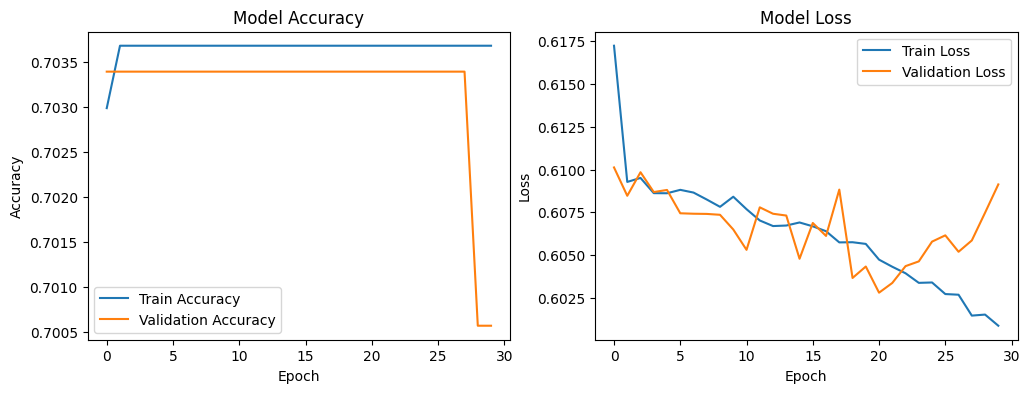

In [47]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
layer_name = 'conv2d_16'
img = X_val[0]
true_label = 'High Threat' if y_val[0] == 1 else 'Low Threat'
prediction = model.predict(np.array([img]), verbose=0)[0][0]
pred_label = 'High Threat' if prediction > 0.5 else 'Low Threat'

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_33']]
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


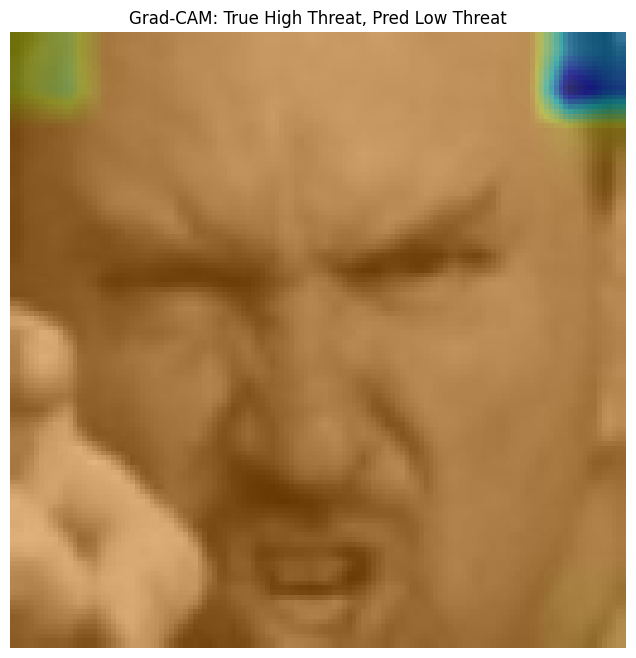

In [51]:
heatmap = grad_cam(model, img, layer_name)
visualize_grad_cam(img, heatmap, f'Grad-CAM: True {true_label}, Pred {pred_label}')

  0%|          | 0/1000 [00:00<?, ?it/s]

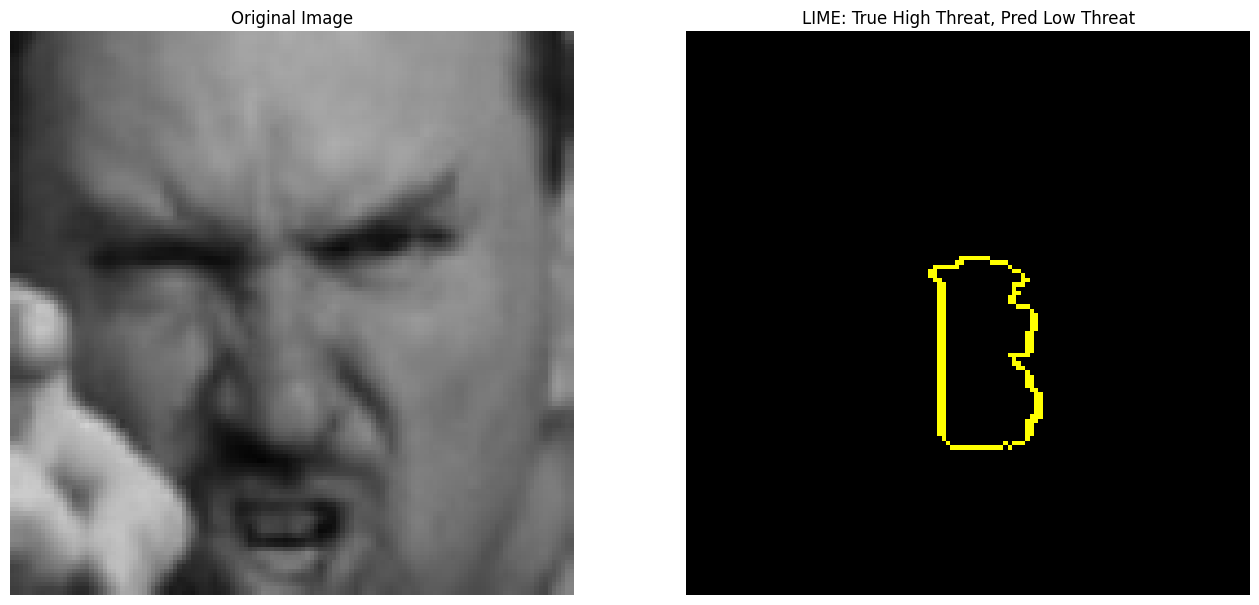

In [55]:
temp, mask = lime_explanation(model, img)
visualize_lime(img, temp, mask, f'LIME: True {true_label}, Pred {pred_label}')

In [62]:
shap_img = shap_explanation(model, img, X_train)
visualize_shap(img, shap_img, f'SHAP: True {true_label}, Pred {pred_label}')

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_33
Received: inputs=['Tensor(shape=(100, 128, 1))']
  warnings.warn(msg)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 1 has 3 dimension(s)

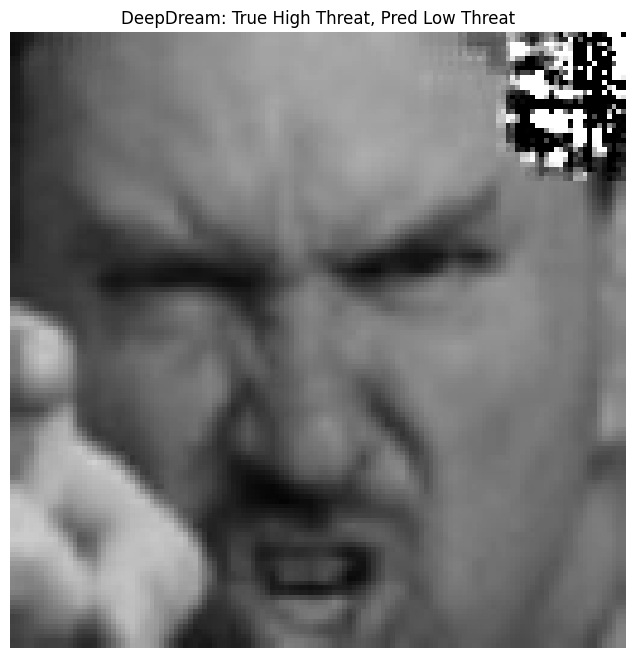

In [66]:
dream_img = deep_dream(model, img, layer_name)
visualize_deep_dream(img, dream_img, f'DeepDream: True {true_label}, Pred {pred_label}')